In [ ]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq, fft, fftfreq, fftshift, ifft
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import pandas as pd
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.signal import welch, get_window
%matplotlib widget 
from funcs_peak_fitting import *
from funcs_dsp import *

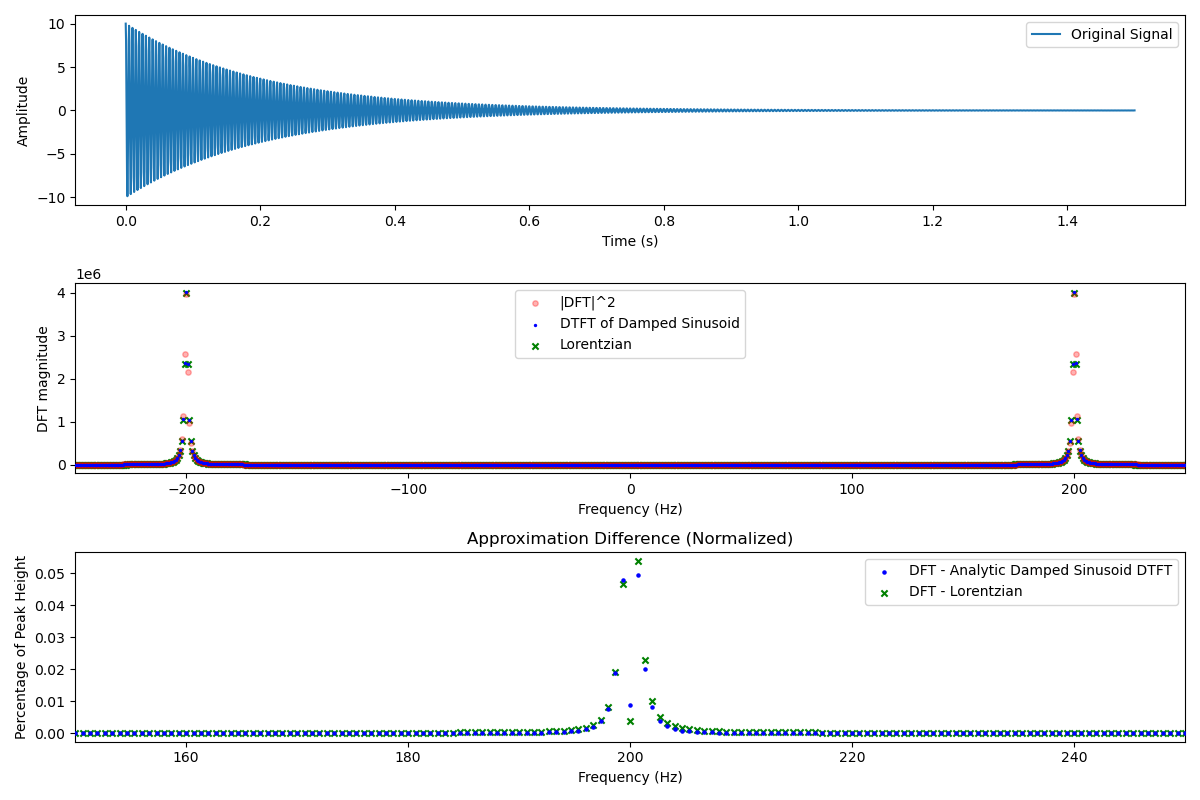

In [ ]:
"Damped sinusoid fitting"
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')


# Generate synthetic data with noise
np.random.seed(42)

fs = 2000
t_max  = 1.5
t = np.linspace(0, t_max, int(t_max * fs))
N = len(t)
f0 = 200
y0 = 0
A = 10
alpha = 5
phi = 0
sigma_noise = 0

y = A * np.cos(f0*2*np.pi*t + phi) * np.exp(-alpha * t) + np.random.normal(0, sigma_noise, t.size)
dft = np.fft.fft(y)
f = np.fft.fftfreq(len(t), 1 / fs)

# Calculate normalized radial frequency
w = 2 * np.pi * f / fs
w0 = 2 * np.pi * f0 / fs

# Calculate the corresponding DFT amplitude
"""
||Approx DTFT||^2 ~ (A * fs / (4pi gamma))^2 * (gamma^2 / [gamma^2 + (f - f0)^2])
Lorentz = amp * (gamma^2 / [gamma^2 + (f - f0)^2])
"""
gamma = alpha / (2 * np.pi)
equivalent_amp = (A * fs / (4 * np.pi * gamma))**2


# Generate simulated lineshapes
dft_squared = np.abs(dft)**2
exact_damped_sinusoid_DTFT_squared = np.abs(damped_sinusoid_DTFT(w, w0, A, alpha, phi, fs))**2
lorentz_minimal_simulation = Lorentzian(f, f0, y0, equivalent_amp, gamma) + Lorentzian(f, -f0, y0, equivalent_amp, gamma)


# Plot the results
n_plots = 3
plt.figure(figsize=(12, 8))

plt.subplot(n_plots, 1, 1)
plt.plot(t, y, label="Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()



plt.subplot(n_plots, 1, 2)
plt.scatter(f, dft_squared, label="|DFT|^2", s=15, alpha=0.3, color='red', zorder = 2)
plt.scatter(f, exact_damped_sinusoid_DTFT_squared, label='DTFT of Damped Sinusoid', color='blue', s=2, zorder=3)
plt.scatter(f, lorentz_minimal_simulation, label="Lorentzian", color='green', marker = 'x', s=20, zorder=1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("DFT magnitude")
plt.xlim(-250, 250)
plt.legend()

plt.subplot(n_plots, 1, 3)
plt.scatter(f, np.abs(dft_squared - exact_damped_sinusoid_DTFT_squared)/equivalent_amp, color='blue', s=5, zorder=3, label="DFT - Analytic Damped Sinusoid DTFT")
plt.scatter(f, np.abs(dft_squared - lorentz_minimal_simulation)/equivalent_amp, color='green', marker = 'x', s=20, zorder=1, label="DFT - Lorentzian")
plt.title("Approximation Difference (Normalized)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Percentage of Peak Height")
plt.xlim(150, 250)
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
"Toy Voigt Fitting"
# Generate synthetic data with noise
np.random.seed(42)
x = np.linspace(2100, 2200, 2000)
x0, y0, amp, gamma, sigma = 2150, 0, 1, 1e-10, 1
y_true = Voigt(x, x0, y0, amp, gamma, sigma)
noise = np.random.normal(0, 0.05, x.size)
y = y_true + noise

p0 = (x0, y0, amp, gamma, sigma)
fitted_params, covariance = curve_fit(Voigt, x, y, p0=p0)

# Extract the fitted parameters
x0_fitted, y0_fitted, amp_fitted, sigma_fitted, gamma_fitted = fitted_params
print("Fitted Parameters:")
print(f"x0: {x0_fitted:.3f}, y0: {y0_fitted:.3f}, Amplitude: {amp_fitted:.3f}, Sigma: {sigma_fitted:.3f}, Gamma: {gamma_fitted:.3f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, y_true, 'k--', label='True Voigt Profile', zorder=2)
plt.plot(x, Voigt(x, *fitted_params), 'r-', label='Fitted Voigt Profile', zorder=1)
# plt.plot(x, Gauss(x, x0, y0, amp, sigma), label="Gaussian")
# plt.plot(x, Lorentz(x, x0, y0, amp, gamma), label="Lorentz")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nonlinear Curve Fitting for a Voigt Distribution")
plt.show()


Detected HWHM: 10.00
Detected amplitude: 10.00
MSE: 0.00
Detected HWHM (dB version): 11.68
Detected amplitude (dB version): 2.95
MSE (dB version): 0.00


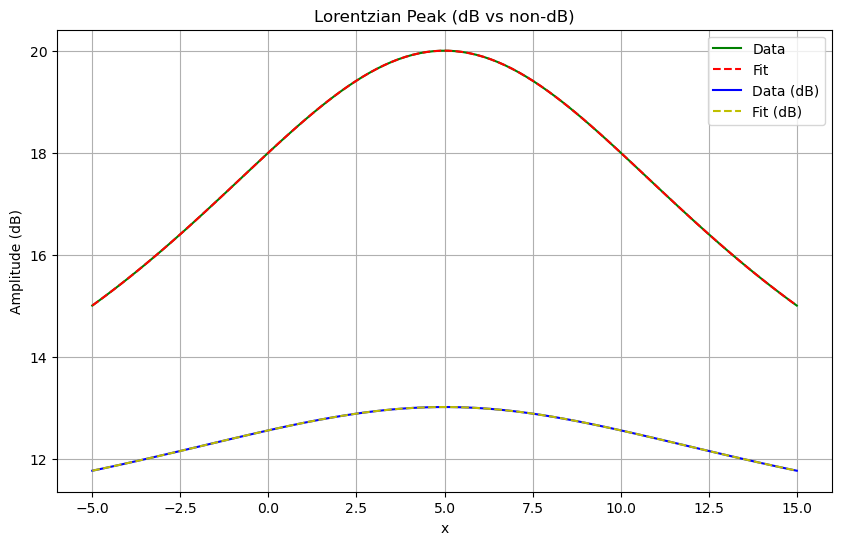

In [ ]:
# What if we fit to a convolved lorentzian?
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from funcs_peak_fitting import Lorentzian, Lorentzian_conv



# Generate frequency axis
N = 32768
sr = 44100
f = fftfreq(N, 1/sr)

# Parameters of our "true underlying" spectrum
amp = 10.0  # Height of the peak
f0 = 100       # Center of the peak
y0 = 10
gamma = 10.0      # Half width at half maximum (HWHM)

# Generate the lorentzian as it would come in after leakage
y_conv = Lorentzian_conv(f, f0, y0, amp, gamma, N, fs)

# Fit the data
popt = fit_lorentzian(x, y)
x0_fit, y0_fit, amplitude_fit, gamma_fit = popt

# Output the detected FWHM
print(f"Detected HWHM: {gamma_fit:.2f}")
print(f"Detected amplitude: {amplitude_fit:.2f}")
print(f"MSE: {np.mean((y - Lorentzian(x, *popt))**2):.2f}")

# Fit the data
popt_dB = fit_lorentzian(x, y_db)
x0_fit_dB, y0_fit_dB, amplitude_fit_dB, gamma_fit_dB  = popt_dB
# Output the detected FWHM
print(f"Detected HWHM (dB version): {gamma_fit_dB:.2f}")
print(f"Detected amplitude (dB version): {amplitude_fit_dB:.2f}")
print(f"MSE (dB version): {np.mean((y - Lorentzian(x, *popt))**2):.2f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'g-', label='Data')
plt.plot(x, Lorentzian(x, *popt), 'r--', label='Fit')
plt.plot(x, y_db, 'b-', label='Data (dB)')
plt.plot(x, Lorentzian(x, *popt_dB), 'y--', label='Fit (dB)')
plt.title(f"Lorentzian Peak (dB vs non-dB)")
plt.xlabel('x')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.grid(True)
plt.show()



Detected HWHM: 10.00
Detected amplitude: 10.00
MSE: 0.00
Detected HWHM (dB version): 11.68
Detected amplitude (dB version): 2.95
MSE (dB version): 0.00


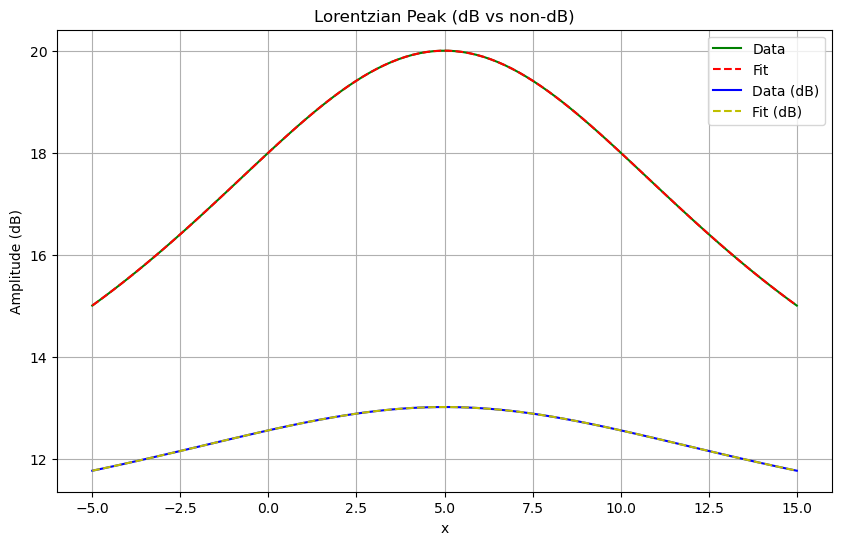

In [7]:
# What if we do our fitting in the dB scale like Chris did?
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from funcs_peak_fitting import Lorentzian

# Convert to dB with a small offset to avoid log(0)
def to_db(y, offset=1e-10):
    return 10 * np.log10(y + offset)

# Generate synthetic data
def generate_data(x0, y0, amp, gamma, x_min, x_max, num_points):
    x = np.linspace(x_min, x_max, num_points)
    y = Lorentzian(x, x0, y0, amp, gamma)
    y_db = to_db(y)
    return x, y, y_db

# Curve fitting function
def fit_lorentzian(x, y_db):
    # Initial guesses for x0, y0, amp, gamma
    initial_guess = [1, 1, 1.0, 10]
    popt, _ = curve_fit(Lorentzian, x, y_db, p0=initial_guess)
    return popt

# Parameters
amp = 10.0  # Height of the peak
x0 = 5         # Center of the peak
y0 = 10
gamma = 10.0      # Half width at half maximum (HWHM)
x_min = x0 - 10.0
x_max = x0 + 10.0
num_points = 100

# Generate data
x, y, y_db = generate_data(x0, y0, amp, gamma, x_min, x_max, num_points)

# Fit the data
popt = fit_lorentzian(x, y)
x0_fit, y0_fit, amplitude_fit, gamma_fit = popt

# Output the detected FWHM
print(f"Detected HWHM: {gamma_fit:.2f}")
print(f"Detected amplitude: {amplitude_fit:.2f}")
print(f"MSE: {np.mean((y - Lorentzian(x, *popt))**2):.2f}")

# Fit the data
popt_dB = fit_lorentzian(x, y_db)
x0_fit_dB, y0_fit_dB, amplitude_fit_dB, gamma_fit_dB  = popt_dB
# Output the detected FWHM
print(f"Detected HWHM (dB version): {gamma_fit_dB:.2f}")
print(f"Detected amplitude (dB version): {amplitude_fit_dB:.2f}")
print(f"MSE (dB version): {np.mean((y - Lorentzian(x, *popt))**2):.2f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'g-', label='Data')
plt.plot(x, Lorentzian(x, *popt), 'r--', label='Fit')
plt.plot(x, y_db, 'b-', label='Data (dB)')
plt.plot(x, Lorentzian(x, *popt_dB), 'y--', label='Fit (dB)')
plt.title(f"Lorentzian Peak (dB vs non-dB)")
plt.xlabel('x')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
""" Double checking my convolutions """
# Parameters
nperseg = 32768
fs = 44100  # Sampling frequency
pad_factor = 8 # Zero-padding factor
f0 = 3000 # Frequency center
y0 = 0 # Offset
amp = 1 # Amplitude 
gamma = 2 # HWHM

# Calculate some padding related things
pad_width = int(nperseg * pad_factor / 2)
N_padded = nperseg + pad_width * 2

# Generate the windows
boxcar_window = get_window('boxcar', nperseg)

# Zero-padding the windows (adding zeros on either side)
zero_padded_boxcar = np.pad(boxcar_window, pad_width)  # Pad with zeros to N_padded length

# Compute the Fourier Transform of the zero-padded windows
boxcar_ft = fft((zero_padded_boxcar))
boxcar_mags = np.abs(boxcar_ft)

# Get frequency axis and normalized radial frequency axis
f = fftfreq(N_padded, 1/fs)
w_hat = 2 * np.pi * f / fs

# Plot
plt.figure(figsize=(8, 4))
plot_width = 10

plt.subplot(2, 2, 2)
plt.scatter(f, boxcar_mags, s=1)
plt.title('True Boxcar Window Mags (Padded)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-plot_width, plot_width)

plt.subplot(2, 2, 1)
plt.scatter(f, np.abs(boxcar_DTFT(w_hat, nperseg, fs)), s=1)
plt.xlim(-plot_width, plot_width)
plt.title("Analytically Derived Boxcar Window Mags")

plt.subplot(2, 2, 3)
plt.scatter(f, Lorentzian(f, f0, y0, amp, gamma), s=1)
plt.xlim(f0 - plot_width, f0 + plot_width)
plt.title("Lorentz Mags")

plt.subplot(2, 2, 4)
plt.scatter(f, Lorentzian_conv(f, f0, y0, amp, gamma, nperseg, fs), s=1)
plt.xlim(f0 - plot_width, f0 + plot_width)
plt.title("Convolved Lorentz Mags")

plt.tight_layout()
plt.show()

